# Weather data and solar radiation

Objetives:

- Obtain weather data from Energy Plus 
- Read weather data 
- Find solar radiation on a tilted surface 
- Visualize and discuss the data 


## Obtain weather data from EnergyPlus files

### Download data file

Download the weather file with extension .epw from http://climate.onebuilding.org or from https://energyplus.net/weather; for example: `FRA_Lyon.074810_IWEC.epw` or `FRA_AR_Lyon-Bron.AP.074800_TMYx.2004-2018`. 

### Read weather data


In [1]:
from dm4bem import read_epw, sol_rad_tilt_surf

filename = 'FRA_Lyon.074810_IWEC.epw'
# filename = 'FRA_AR_Lyon-Bron.AP.074800_TMYx.2004-2018.epw'

In weather file, data corresponding to each month is from another year. 

In [2]:
[data, meta] = read_epw(filename, coerce_year=None)
month_year = data['month'].astype(str) + '-' + data['year'].astype(str)
print(f"Months - years in the dataset: {sorted(set(month_year))}")

Months - years in the dataset: ['1-1983', '10-1999', '11-1991', '12-1986', '2-1985', '3-1998', '4-1995', '5-1986', '6-1993', '7-1982', '8-1993', '9-1988']


From the dataset, select air temperature, normal solar radiation and diffuse solar radiationreceived during 60 minutes prior to timestamp. Change all year too the same year, e.g. 2000.

In [3]:
weather_data = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
weather_data.index = weather_data.index.map(lambda t: t.replace(year=2000))

Select a period and the air temperature, normal solar radiation and diffuse solar radiationreceived during 60 minutes prior to timestamp. 

In [4]:
start_date = '2000-6-29'
end_date = '2000-7-22'

weather_data = weather_data[(weather_data.index >= start_date) & (
    weather_data.index < end_date)]
del data

<AxesSubplot:>

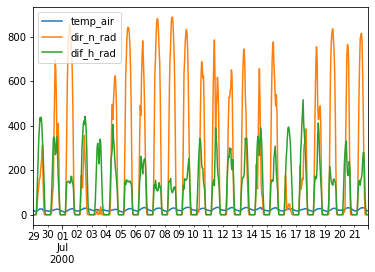

In [5]:
weather_data.plot()

### Solar radiation on a tilted surface

Given a tilted wall and knowing the albedo of the surface in front of it, calculate the direct, diffuse and reflected radiation incident on the wall.

<AxesSubplot:>

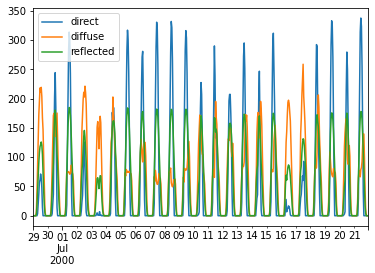

In [6]:
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2

rad_surf = sol_rad_tilt_surf(
    weather_data, surface_orientation, albedo)

rad_surf.plot()

## Solar radiation on a tilted surface `sol_rad_tilt_sur`

Let’s consider a tilted surface having another surface (e.g., ground) in front of it. Given the weather data, the surface orientation, and the albedo of the ground in front of the surface, find the direct, diffuse and reflected solar radiation for this surface. 

In [7]:
import numpy as np
import pandas as pd

B = surface_orientation['slope']
Z = surface_orientation['azimuth']
L = surface_orientation['latitude']

# Transform degrees in radians
B = B * np.pi / 180
Z = Z * np.pi / 180
L = L * np.pi / 180

n = weather_data.index.dayofyear

**Total solar radiation** is the amount of radiation received on a surface during the number of minutes preceding the time indicated:

$$ G_{sr} = G_{dir} + G_{dif} + G_r$$

where:

- $G_{dir}$ **direct normal** or **beam radiation**: amount of solar radiation received directly from the solar disk on a surface perpendicular to the sun’s rays, during the number of minutes preceding the time indicated, Wh/m².

- $G_{dif}$ **diffuse radiation**: amount of solar radiation received after scattering by the atmosphere, Wh/m². Note: it does not include the diffuse infrared radiation emitted by the atmosphere.

- $G_r$ **total solar radiation coming by reflection** from the surface in front of the wall (usually, ground), Wh/m².

### Direct radiation, $G_{dir}$

The direct radiation on the surface, $G_{dir}$, depends on the *direct normal (or beam) radiation*, $G_n$, and the *incidence angle*, $\theta$, between the solar beam and the normal to the wall [2] (§11.2.1).

In order to calculate the *incidence angle*, $\theta$, we need:

- $\phi$ *latitude*, the angle between the position and the Equator, ranging from 0° at the Equator to 90° at the North Pole and -90° at the South Pole. $-90 ^{\circ} \leq \phi \leq 90 ^{\circ}$

- $\beta$ *slope*, the angle between the plane of the surface and the horizontal. $\beta > 90 ^{\circ}$

- $\gamma$ *azimuth*, the angle between the projection on a horizontal plane of the normal to the surface and the local meridian; south is zero, east negative, and west positive. $-180 ^{\circ} \leq \gamma \leq 180 ^{\circ}$.

- $\delta$ *declination angle*, the angle between the sun at noon (i.e., when the sun is on the local meridian) and the plane of the equator, north positive [1](eq. 1.6.1a), [2](§11.2.1.1, eq. (78)):
$$ \delta = 23.45 \sin \left( 360 \frac{284 + n}{365} \right)$$

In [8]:
declination_angle = 23.45 * np.sin(360 * (284 + n) / 365 * np.pi / 180)
d = declination_angle * np.pi / 180

- $\omega$ *hour angle*, the angle between the sun and the local meridian due to rotation of the earth around its axis at 15° per hour [1]:

$$ \omega = 15\left ( hour + \frac{minute}{60} - 12 \right )$$

where *hour* and *minute* is the solar time:

In [9]:
hour = weather_data.index.hour
minute = weather_data.index.minute + 60
hour_angle = 15 * ((hour + minute / 60) - 12)
h = hour_angle * np.pi / 180

$-180 ^{\circ} \leq \omega \leq 180 ^{\circ}$. $\omega < 0$ in the morning, $\omega = 0$ at noon, and $\omega > 0$ in the afternoon. Hour angle is used with the declination to give the direction of  apoint on the celestial sphere.

The **incidence angle**, $\theta$, is the angle between the solar beam on the surface and the normal to the surface [1](eq. 1.6.2), [2] (eq. 78):

$$\theta = \arccos (\sin \delta \sin \phi \cos \beta - \sin \delta \cos \phi \sin \beta \cos \gamma + \cos \delta \cos \phi \cos \beta \cos \omega + \cos \delta \sin \phi \sin \beta \cos \gamma \cos \omega + \cos \delta \sin \beta \sin \gamma \sin \omega)$$

In [10]:
theta = np.sin(d) * np.sin(L) * np.cos(B)
theta -= np.sin(d) * np.cos(L) * np.sin(B) * np.cos(Z)
theta += np.cos(d) * np.cos(L) * np.cos(B) * np.cos(h)
theta += np.cos(d) * np.sin(L) * np.sin(B) * np.cos(Z) * np.cos(h)
theta += np.cos(d) * np.sin(B) * np.sin(Z) * np.sin(h)
theta = np.array(np.arccos(theta))
theta[theta > (np.pi / 2)] = np.pi / 2

The **direct radiation**, $G_{dir}$ on the surface is:

$$G_{dir} = G_{dir,n} \cos \theta$$

where *direct normal radiation* or *beam radiation*, $G_n$, is the amount of solar radiation (in Wh/m²) received directly from the solar disk on the surface perpendicular to the sun’s rays, during the number of minutes preceding the time indicated. It is given by weather data.

In [11]:
dir_rad = weather_data["dir_n_rad"] * np.cos(theta)
dir_rad[dir_rad < 0] = 0

### Diffuse Radiation, $G_{dif}$

The diffuse radiation on the wall is a function on its slope, $\beta$, and 
the isotropic diffuse solar radiation, $G_{dif,h}$, [2](§1.2.1.2, eq. 79, p. 31):

$$ G_{dif} = G_{dif,h} (1 + \cos \beta) / 2$$

In [12]:
dif_rad = weather_data["dif_h_rad"] * (1 + np.cos(B)) / 2

### Solar radiation reflected by the ground

Considering the radiation reflected by the ground as isotropic, the reflected radiation that gets onto the wall is a function of its slope, albedo and total horizontal radaition [2](§11.2.1.3).

The normal horizontal radiation is [2] (eq. 80):
$$ G_{dir,h} = G_{dn} \sin \gamma$$

In [13]:
gamma = np.cos(d) * np.cos(L) * np.cos(h)
gamma += np.sin(d) * np.sin(L)
gamma = np.array(np.arcsin(gamma))
gamma[gamma < 1e-5] = 1e-5

dir_h_rad = weather_data["dir_n_rad"] * np.sin(gamma)

The total radiation received by reflection is:
$$G_r = (G_{dir,h} + G_{dif,h}) albedo (1 - \cos \beta)/2$$

In [14]:
ref_rad = (dir_h_rad + weather_data["dif_h_rad"]) * albedo
ref_rad *= (1 - np.cos(B) / 2)

### Definitions

$G_{dir,n}$ **Direct normal** or **beam radiation**. Amount of solar radiation in Wh/m² received directly from the solar disk on a surface perpendicular to the sun’s rays, during the number of minutes preceding the time indicated.

$G_{dif,h}$ **Diffuse horizontal radiation**. Amount of solar radiation in Wh/m² received after scattering by the atmosphere. This definition distinguishes the diffuse solar radiation from infrared radiation emitted by the atmosphere.

**Total Solar Radiation**. Total amount of direct and diffuse solar radiation in Wh/m² received on a  surface during the number of minutes preceding the time indicated.

**Global radiation.** Total solar radiation given on a horizontal surface.

**Solar Time.** Time based on the apparent position of the sun in the sky with noon the time when the sun crosses the observer meridian. 

### Definitions for angles (in degrees)

$\phi$ **Latitude.** Angle between the position and the Equator, ranging from 0° at the Equator to 90° at the North Pole and -90° at the South Pole. $-90 ^{\circ} \leq \phi \leq 90 ^{\circ}$

$\beta$ **Slope.** Angle between the plane of the surface and the horizontal. $\beta > 90 ^{\circ}$

$\gamma$ **Azimuth.** Angle between the projection on a horizontal plane of the normal to the surface and the local meridian; south is zero, east negative, and west positive. $-180 ^{\circ} \leq \gamma \leq 180 ^{\circ}$.

$\delta$ **Declination.** Angle between the sun at noon (i.e., when the sun is on the local meridian) and the plane of the equator, north positive [1, eq. 1.6.1a):

$$ \delta = 23.45 \sin \left( 360 \frac{284 + n}{365} \right)$$

where $n$ is the day of the year. $-23.45 ^{\circ} \leq \delta \leq 23.45 ^{\circ}$. Declination is used with hour angle to give the direction of apoint on the celestial sphere.

$\omega$ **Hour angle.** Angle between the sun and the local meridian due to rotation of the earth around its axis at 15° per hour [1]:

$$ \omega = 15\left ( hour + \frac{minute}{60} - 12 \right )$$

where *hour* and *minute* is the solar time. $-180 ^{\circ} \leq \omega \leq 180 ^{\circ}$; $\omega < 0$ in the morning, $\omega = 0$ at noon, and $\omega > 0$ in the afternoon. Hour angle is used with the declination to give the direction of  apoint on the celestial sphere.

$\theta$ **Incidence.** Angle between the solar beam on the surface and the normal to the surface [1, eq. 1.6.2]:

$$\theta = \arccos (\sin \delta \sin \phi \cos \beta - \sin \delta \cos \phi \sin \beta \cos \gamma + \cos \delta \cos \phi \cos \beta \cos \omega + \cos \delta \sin \phi \sin \beta \cos \gamma \cos \omega + \cos \delta \sin \beta \sin \gamma \sin \omega)$$



## References

1. J.A. Duffie, W. A. Beckman, N. Blair (2020) Solar Engineering of Thermal Processes, 5th ed. John Wiley & Sons, Inc. ISBN 9781119540281

2. Réglementation Thermique 2005. Méthode de calcul Th-CE. Annexe à l’arrêté du 19 juillet 2006